<a href="https://colab.research.google.com/github/kjjwwo/cv_study/blob/main/c1_t1_a1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
!pip install scikit-image
!pip install scikit-learn
!pip install opencv-python
!pip install opencv-contrib-python
!pip install numpy
!pip install matplotlib
'''

'\n!pip install scikit-image\n!pip install scikit-learn\n!pip install opencv-python\n!pip install opencv-contrib-python\n!pip install numpy\n!pip install matplotlib\n'

CV challenge
C1
1) LBP + HoG + GLCM + scale 조정 + pca

C2
1) nn.Linear(256) 하나 더 추가, 2 fold 실시, lr = 0.001
2) 5 fold cross validation 실시 (3회 반복) + lr = 0.0001
3) 4 fold cv 실시 (2회 반복) , lr = 0.0001
4) nn.Linear 하나 더 추가, 3 fold cv, lr = 0.0007
5) nn.Linear 하나 더 추가, 3 fold cv, lr = 0.00075, patience = 10
6) nn.Linear 하나 더 추가, 4 fold cv, lr = 0.0008, patience = 10
7) data Aug, nn.Linear 하나 더 추가, 4 fold cv, lr = 0.00077, patience = 10
8)  nn.Linear 하나 더 추가, 4 fold cv, lr = 0.00123, patience = 10
9)  nn.Linear 두개 추가, 4 fold cv, lr = 0.00073, patience = 10
10) nn.Linear 두개 추가 + dropout(0.3), 4 fold cv, lr = 0.00067, patience = 10

11) nn.Linear 두개 추가 + dropout(0.4), 4 fold cv, lr = 0.00061, patience = 10


In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Prepare image data

In [ ]:
!git clone https://github.com/hbcbh1999/recaptcha-dataset.git
!rm -rf ./recaptcha-dataset/Large/Mountain/
!rm -rf ./recaptcha-dataset/Large/Other/
!rm -rf ./recaptcha-dataset/Large/readme.txt

Cloning into 'recaptcha-dataset'...
remote: Enumerating objects: 11745, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 11745 (delta 0), reused 0 (delta 0), pack-reused 11742 (from 1)
Receiving objects: 100% (11745/11745), 395.63 MiB | 41.00 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (11778/11778), done.


### Preprocessing

In [ ]:
image_path = './recaptcha-dataset/Large/Bicycle/Bicycle (3).png'

# point processing
# load BGR image
image = cv2.imread(image_path)

# BGR -> gray
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# BGR -> HSV
hsi = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# gray -> contrast stretching
stretch = cv2.equalizeHist(gray)

# area processing
# noise filtering
blur_gauss = cv2.GaussianBlur(image, ksize=(3, 3), sigmaX=1)
blur_median = cv2.medianBlur(image, ksize=3)
blur_mean = cv2.blur(image, ksize=(3, 3))

# edge
edge_canny = cv2.Canny(gray, 100, 200)
edge_sobelx = cv2.Sobel(gray, ddepth=-1, dx=1, dy=0, delta=128)
edge_sobely = cv2.Sobel(gray, ddepth=-1, dx=0, dy=1, delta=128)

# sharpening
sharp = cv2.addWeighted(image, 2, blur_gauss, -1, 0)

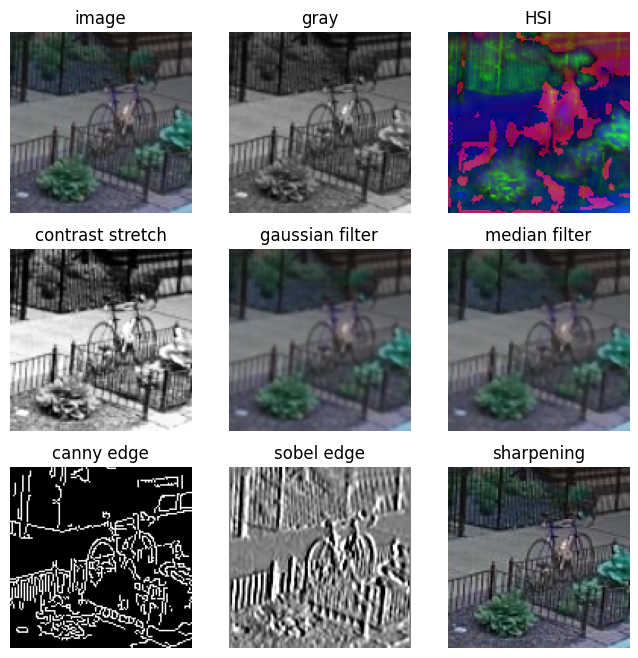

In [ ]:
# visualization
plt.figure(figsize=(8, 8))

plt.subplot(3, 3, 1)
plt.title('image')
plt.axis('off')
plt.imshow(image)

plt.subplot(3, 3, 2)
plt.title('gray')
plt.axis('off')
plt.imshow(gray, cmap='gray')

plt.subplot(3, 3, 3)
plt.title('HSI')
plt.axis('off')
plt.imshow(hsi)

plt.subplot(3, 3, 4)
plt.title('contrast stretch')
plt.axis('off')
plt.imshow(stretch, cmap='gray')

plt.subplot(3, 3, 5)
plt.title('gaussian filter')
plt.axis('off')
plt.imshow(blur_gauss)

plt.subplot(3, 3, 6)
plt.title('median filter')
plt.axis('off')
plt.imshow(blur_median)

plt.subplot(3, 3, 7)
plt.title('canny edge')
plt.axis('off')
plt.imshow(edge_canny, cmap='gray')

plt.subplot(3, 3, 8)
plt.title('sobel edge')
plt.axis('off')
plt.imshow(edge_sobelx, cmap='gray')

plt.subplot(3, 3, 9)
plt.title('sharpening')
plt.axis('off')
plt.imshow(sharp)

## Feature extraction
### histogram

<BarContainer object of 128 artists>

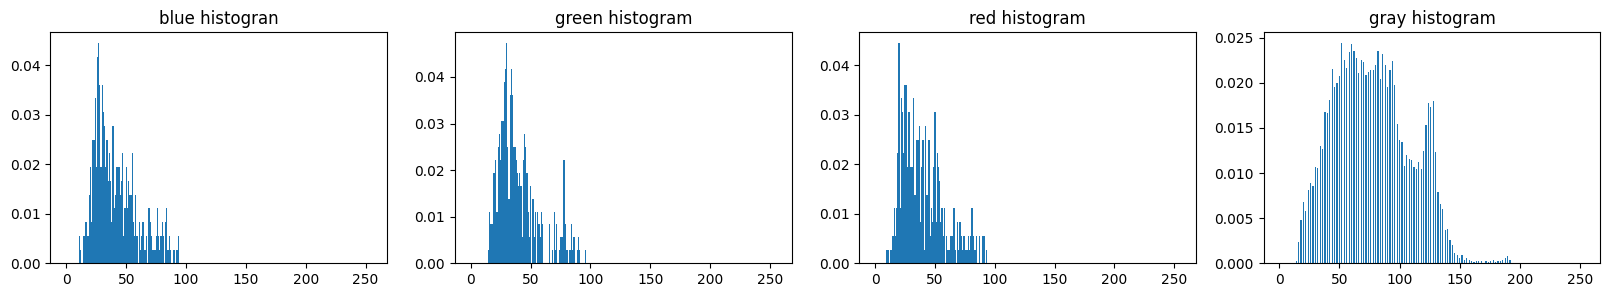

In [ ]:
def norm_hist(hist):
    # Normalize the histogram
    hist = hist.astype('float')
    hist /= hist.sum()
    return hist

# color histogram
hist_b, bins_b = np.histogram(image[0], bins=256, range=(0, 256))
hist_g, bins_g = np.histogram(image[1], bins=256, range=(0, 256))
hist_r, bins_r = np.histogram(image[2], bins=256, range=(0, 256))
hist_b = norm_hist(hist_b)    # 256-d
hist_g = norm_hist(hist_g)    # 256-d
hist_r = norm_hist(hist_r)    # 256-d

# gray histogram
hist_gray, bins_gray = np.histogram(gray, bins=128, range=(0, 256))
hist_gray = norm_hist(hist_gray)    # 128-d

# visualization
plt.figure(figsize=(20, 3))

plt.subplot(1, 4, 1)
plt.title('blue histogran')
plt.bar(bins_b[:-1], hist_b, width=1)

plt.subplot(1, 4, 2)
plt.title('green histogram')
plt.bar(bins_g[:-1], hist_g, width=1)

plt.subplot(1, 4, 3)
plt.title('red histogram')
plt.bar(bins_r[:-1], hist_r, width=1)

plt.subplot(1, 4, 4)
plt.title('gray histogram')
plt.bar(bins_gray[:-1], hist_gray, width=1)

### LBP

<BarContainer object of 64 artists>

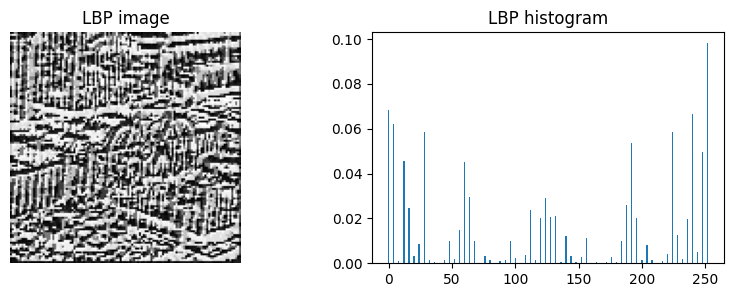

In [ ]:
from skimage.feature import local_binary_pattern

# LBP
lbp = local_binary_pattern(gray, P=8, R=1)

hist_lbp, bin_lbp = np.histogram(lbp.ravel(), bins=64, range=(0, 256))
hist_lbp = norm_hist(hist_lbp)    # 64-d

# visualization
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.title('LBP image')
plt.axis('off')
plt.imshow(lbp, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('LBP histogram')
plt.bar(bin_lbp[:-1], hist_lbp, width=1)

### GLCM

In [ ]:
# GLCM
from skimage.feature import graycomatrix, graycoprops

glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=False, normed=True)

max_prob = np.max(glcm)
contrast = graycoprops(glcm, 'contrast')
dissimilarity = graycoprops(glcm, 'dissimilarity')
homogeneity = graycoprops(glcm, 'homogeneity')
energy = graycoprops(glcm, 'energy')
correlation = graycoprops(glcm, 'correlation')

print('Max probability:', max_prob)
print('Contrast:', contrast[0][0])
print('Dissimilarity:', dissimilarity[0][0])
print('Homogeneity:', homogeneity[0][0])
print('Energy:', energy[0][0])
print('Correlation:', correlation[0][0])

Max probability: 0.002240896358543417
Contrast: 184.04964985994397
Dissimilarity: 9.225840336134455
Homogeneity: 0.1607216027232011
Energy: 0.019046589196084266
Correlation: 0.9078959515410305


In [ ]:
'''
    i j
'''
glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=False, normed=True)

'''
    i
    j
'''
glcm = graycomatrix(gray, distances=[1], angles=[np.pi/2], levels=256, symmetric=False, normed=True)

'''
    i
      j
'''
glcm = graycomatrix(gray, distances=[1], angles=[np.pi/4], levels=256, symmetric=False, normed=True)

### Law's texture

In [ ]:
# Law's texture
from scipy import signal as sg

def laws_texture(gray):
    (rows, cols) = gray.shape[:2]

    smooth_kernel = (1/25)*np.ones((5,5))
    gray_smooth = sg.convolve(gray, smooth_kernel,"same")
    gray_processed = np.abs(gray - gray_smooth)

    filter_vectors = np.array([[ 1,  4,  6,  4, 1],    # L5
                               [-1, -2,  0,  2, 1],    # E5
                               [-1,  0,  2,  0, 1],    # S5
                               [ 1, -4,  6, -4, 1]])   # R5

    # 0:L5L5, 1:L5E5, 2:L5S5, 3:L5R5,
    # 4:E5L5, 5:E5E5, 6:E5S5, 7:E5R5,
    # 8:S5L5, 9:S5E5, 10:S5S5, 11:S5R5,
    # 12:R5L5, 13:R5E5, 14:R5S5, 15:R5R5
    filters = list()
    for i in range(4):
        for j in range(4):
            filters.append(np.matmul(filter_vectors[i][:].reshape(5,1),
                                     filter_vectors[j][:].reshape(1,5)))

    conv_maps = np.zeros((rows, cols,16))
    for i in range(len(filters)):
        conv_maps[:, :, i] = sg.convolve(gray_processed,
                                         filters[i],'same')

    texture_maps = list()
    texture_maps.append((conv_maps[:, :, 1]+conv_maps[:, :, 4])//2)     # L5E5 / E5L5
    texture_maps.append((conv_maps[:, :, 2]+conv_maps[:, :, 8])//2)     # L5S5 / S5L5
    texture_maps.append((conv_maps[:, :, 3]+conv_maps[:, :, 12])//2)    # L5R5 / R5L5
    texture_maps.append((conv_maps[:, :, 7]+conv_maps[:, :, 13])//2)    # E5R5 / R5E5
    texture_maps.append((conv_maps[:, :, 6]+conv_maps[:, :, 9])//2)     # E5S5 / S5E5
    texture_maps.append((conv_maps[:, :, 11]+conv_maps[:, :, 14])//2)   # S5R5 / R5S5
    texture_maps.append(conv_maps[:, :, 10])                            # S5S5
    texture_maps.append(conv_maps[:, :, 5])                             # E5E5
    texture_maps.append(conv_maps[:, :, 15])                            # R5R5
    texture_maps.append(conv_maps[:, :, 0])                             # L5L5 (use to norm TEM)

    TEM = list()
    for i in range(9):
        TEM.append(np.abs(texture_maps[i]).sum() / np.abs(texture_maps[9]).sum())

    return TEM

laws = laws_texture(gray)    # 9-d
print(laws)

[np.float64(0.06405685782420119), np.float64(0.1268513550229604), np.float64(0.12794970496351235), np.float64(0.031271688435861714), np.float64(0.013639978898129507), np.float64(0.026063367594507274), np.float64(0.01917102946493686), np.float64(0.02240868564329823), np.float64(0.05689975125547207)]


### SIFT

22


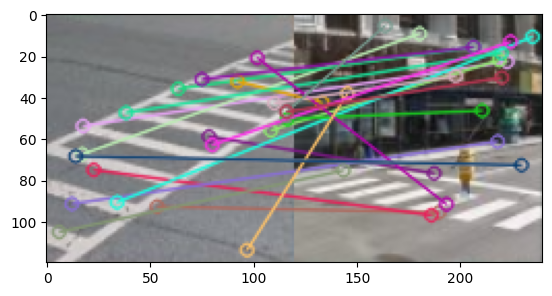

In [ ]:
image1 = cv2.imread('./recaptcha-dataset/Large/Crosswalk/Cross (2).png')
image2 = cv2.imread('./recaptcha-dataset/Large/Crosswalk/Cross (5).png')

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1, None)    # des: (n, 128)
kp2, des2 = sift.detectAndCompute(image2, None)    # des: (n, 128)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1,des2)
print(len(matches))
matches = sorted(matches, key = lambda x:x.distance)
image3 = cv2.drawMatches(image1,kp1,image2,kp2,matches[:],None,flags=2)
plt.imshow(image3)
plt.show()

### HoG

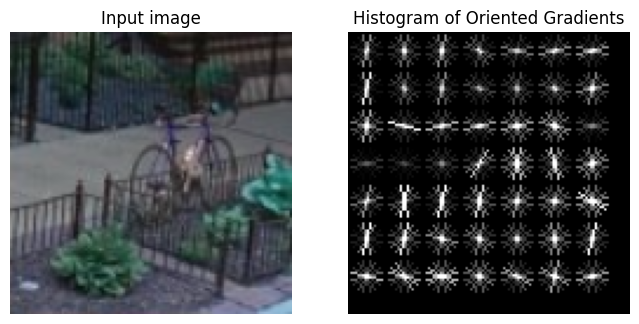

In [ ]:
from skimage.feature import hog
from skimage import data, exposure

# Extract HoG features
# fd: 8 * (image.shape[0]//16)*(image.shape[1]//16) dimension
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

# Visualize HoG image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap='gray')
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
!pip install scikit-image scikit-learn opencv-python tqdm

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# def feature_extracting(image, resize_to=(128,128), lbp_P=8, lbp_R=1, hog_pixels_per_cell=(8, 8), hog_cells_per_block=(2, 2)):
#     # Resize
#     image = cv2.resize(image, resize_to, interpolation=cv2.INTER_AREA)

#     # Convert to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


#     # --- LBP ---
#     lbp = local_binary_pattern(gray, P=lbp_P, R=lbp_R, method='uniform')
#     n_bins = lbp_P + 2
#     lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

#     # --- HOG ---
#     hog_feature = hog(gray,
#                       pixels_per_cell=hog_pixels_per_cell,
#                       cells_per_block=hog_cells_per_block,
#                       block_norm='L2-Hys',
#                       visualize=False,
#                       feature_vector=True)

#     hog_feature = MinMaxScaler().fit_transform(hog_feature.reshape(-1, 1)).ravel()

#     # --- GLCM ---
#     glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=False, normed=True)
#     g_features = []
#     props = ['contrast', 'homogeneity', 'energy', 'correlation']
#     for p in props:
#       vals = graycoprops(glcm, p)
#       g_features.extend(vals.flatten())

#     glcm_feature = np.array(g_features)

#     # --- Concatenate ---
#     feature_vector = np.concatenate([lbp_hist, hog_feature, glcm_feature])
#     return feature_vector
import cv2, numpy as np
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops

# LBP
def lbp_feature(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp   = local_binary_pattern(gray, P=8, R=1, method="uniform")
    hist, _ = np.histogram(lbp.ravel(),
                           bins=10,         # uniform LBP(8,1) → 10 bin
                           range=(0, 10),
                           density=True)    # [0,1] 확률분포
    return hist

# HOG
def hog_feature(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (128,128))  # 고정 크기
    feat = hog(gray,
               pixels_per_cell=(8,8),
               cells_per_block=(2,2),
               block_norm="L2-Hys",
               visualize=False,
               feature_vector=True)
    return feat                              # 길이: 3780

# GLCM
def glcm_feature(img,
                 distances=[1],
                 angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (64,64))
    gray = (gray/4).astype(np.uint8)          # 0~63레벨 (levels=64)
    glcm = graycomatrix(gray,
                        distances=distances,
                        angles=angles,
                        levels=64,
                        symmetric=True,
                        normed=True)
    props = ['contrast','correlation','energy','homogeneity']
    feat  = []
    for p in props:
        feat.extend(graycoprops(glcm, p).flatten())  # 4각도×4속성=16
    return np.array(feat)                            # 길이 16

# 전체 결합
def full_feature(img):
    return np.concatenate([lbp_feature(img),
                           hog_feature(img),
                           glcm_feature(img)])


In [ ]:
import os
from tqdm import tqdm

# data_dir   = "/content/recaptcha-dataset/Large"   # 클래스 폴더들이 있는 상위경로
# class_list = sorted(os.listdir(data_dir))

# features, labels = [], []

# for cls_idx, cls_name in enumerate(class_list):
#     cls_path = os.path.join(data_dir, cls_name)
#     for img_name in tqdm(os.listdir(cls_path), desc=f"Extracting {cls_name}"):
#         img = cv2.imread(os.path.join(cls_path, img_name))
#         if img is None: continue
#         features.append(full_feature(img))
#         labels.append(cls_idx)

# X = np.vstack(features)     # (N, D≈3855)
# y = np.array(labels)

# print("Raw feature shape :", X.shape)  # 확인

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)       # 평균0, 표준편차1  ➜  범위 통일

# pca_dim = 256
# pca = PCA(n_components=pca_dim)
# X_pca = pca.fit_transform(X_scaled)

# print("After PCA shape   :", X_pca.shape)

In [ ]:
# np.save("/content/knn_train_features.npy", X_pca)
# np.save("/content/knn_train_labels.npy"  , y)

# # scaler·pca 행렬도 저장해 두면 test 때 그대로 transform 가능
# import joblib
# joblib.dump(scaler, "/content/standard_scaler.pkl")
# joblib.dump(pca   , "/content/pca_transform.pkl")

# print("저장 완료 → KNN 매칭용 DB feature 생성")

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

recaptcha = './recaptcha-dataset/Large'
labels = ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney',
          'Crosswalk', 'Hydrant', 'Motorcycle', 'Palm', 'Traffic Light']

train_features = []
train_labels = []
test_features = []
test_labels = []

for label in labels:
    image_dir = os.path.join(recaptcha, label)
    image_list = os.listdir(image_dir)
    length = len(image_list)
    for i, image_name in enumerate(image_list):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        train_features.append(full_feature(img))
        train_labels.append(label)

classifier = KNeighborsClassifier(n_neighbors = 3)

# Train dataset 조정
X = np.vstack(train_features)     # (N, D≈3855)
y = np.array(train_labels)
print("Raw feature shape :", X.shape)  # 확인

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)       # 평균0, 표준편차1  ➜  범위 통일

pca_dim = 256
pca = PCA(n_components=pca_dim)
X_pca = pca.fit_transform(X_scaled)

print("After PCA shape   :", X_pca.shape)   # 확인

np.save("/content/knn_train_features.npy", X_pca)
np.save("/content/knn_train_labels.npy"  , y)

# scaler·pca 행렬도 저장해 두면 test 때 그대로 transform 가능
import joblib
joblib.dump(scaler, "/content/standard_scaler.pkl")
joblib.dump(pca   , "/content/pca_transform.pkl")

print("저장 완료 → KNN 매칭용 DB feature 생성")

KeyboardInterrupt: 

In [ ]:
# Test dataset 조정
# Test dataset 읽어오기...
import os
import cv2
import numpy as np
import joblib
from sklearn.neighbors import KNeighborsClassifier

# 1. 테스트 이미지 불러오기
query_path = "/content/query"
image_list = sorted(os.listdir(query_path))  # 정렬 중요

# 2. Feature 추출 (LBP + HOG + GLCM)
test_features = []

image_list = sorted([
    fname for fname in os.listdir(query_path)
    if os.path.isfile(os.path.join(query_path, fname)) and fname.lower().endswith(('.png', '.jpg', '.jpeg'))
])

for img_name in image_list:
    img_path = os.path.join(query_path, img_name)
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"이미지 불러오기 실패: {img_path}")
    feat = full_feature(img)
    test_features.append(feat)


scaler = joblib.load("/content/standard_scaler.pkl")
pca    = joblib.load("/content/pca_transform.pkl")

test_X = np.vstack(test_features)
test_X_scaled = scaler.transform(test_X)
test_X_pca = pca.transform(test_X_scaled)

print("최종 test feature shape:", test_X_pca.shape)

# DB feature 불러오기
X_train = np.load("/content/knn_train_features.npy")
y_train = np.load("/content/knn_train_labels.npy")

classifier.fit(X_train, y_train)
predict_labels = classifier.predict(test_X_pca)


최종 test feature shape: (100, 256)


### Task 1: Classification

In [ ]:
predict_labels = classifier.predict(test_X_pca)
print(predict_labels)    # array(100)

['Crosswalk' 'Car' 'Car' 'Hydrant' 'Bridge' 'Crosswalk' 'Bus' 'Bus' 'Car'
 'Bus' 'Palm' 'Hydrant' 'Bus' 'Bridge' 'Car' 'Bus' 'Traffic Light'
 'Bridge' 'Hydrant' 'Bicycle' 'Palm' 'Hydrant' 'Palm' 'Hydrant' 'Hydrant'
 'Car' 'Bridge' 'Palm' 'Bridge' 'Bridge' 'Bridge' 'Car' 'Car' 'Bridge'
 'Bicycle' 'Hydrant' 'Palm' 'Hydrant' 'Car' 'Car' 'Bridge' 'Car' 'Palm'
 'Bus' 'Car' 'Bus' 'Hydrant' 'Car' 'Bridge' 'Palm' 'Bridge' 'Bus'
 'Traffic Light' 'Bridge' 'Palm' 'Bridge' 'Car' 'Car' 'Car' 'Car' 'Palm'
 'Bus' 'Car' 'Car' 'Bridge' 'Bridge' 'Bridge' 'Bus' 'Car' 'Car' 'Bus'
 'Crosswalk' 'Crosswalk' 'Bicycle' 'Traffic Light' 'Palm' 'Car' 'Car'
 'Hydrant' 'Car' 'Traffic Light' 'Palm' 'Car' 'Bus' 'Hydrant' 'Bus' 'Car'
 'Bridge' 'Bridge' 'Crosswalk' 'Car' 'Car' 'Bridge' 'Bus' 'Car' 'Car'
 'Hydrant' 'Bus' 'Traffic Light' 'Crosswalk']


In [ ]:
import csv

with open('c1_t1_a1.csv','w') as file :
    write = csv.writer(file)
    for i, predict_label in enumerate(predict_labels):
        write.writerow([f'query{i+1:03}.png', predict_label])

### Task 2: Retrieval

In [ ]:
neigh_ind = classifier.kneighbors(X=test_X_pca, n_neighbors=10, return_distance=False) # Top-10 results
#neigh_labels = np.array(train_labels)[neigh_ind]
neigh_labels = y_train[neigh_ind]

IndexError: index 5125 is out of bounds for axis 0 with size 708

In [ ]:
print(neigh_labels)    # array(100x10)

[['Bicycle' 'Bus' 'Car' ... 'Crosswalk' 'Car' 'Car']
 ['Bicycle' 'Crosswalk' 'Bicycle' ... 'Crosswalk' 'Bus' 'Bicycle']
 ['Car' 'Car' 'Crosswalk' ... 'Car' 'Bus' 'Bus']
 ...
 ['Palm' 'Traffic Light' 'Traffic Light' ... 'Palm' 'Palm' 'Palm']
 ['Car' 'Car' 'Palm' ... 'Bicycle' 'Car' 'Car']
 ['Bridge' 'Car' 'Car' ... 'Car' 'Car' 'Bridge']]


In [ ]:
import csv

with open('c1_t2_a1.csv','w') as file :
    write = csv.writer(file)
    for i, neigh_label in enumerate(neigh_labels):
        write.writerow([f'query{i+1:03}.png'] + list(neigh_label))